# Artificial Neural Networks and Deep Learning


## ⚙️ Import Libraries
Import the libraries needed for the project and fix the seed for repeatability.

In [1]:
seed = 42

import numpy as np
import random

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import keras_cv as kcv

import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(seed)
tf.random.set_seed(seed)

c:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## ⏳ Load the Data

The data are loaded from the filtered, pre-processed data. For more details, see '''Preprocessing.ipynb''' notebook.

In [2]:
filtered_dataset_path = '../Preprocessing/balanced_dataset.npz'
data = np.load(filtered_dataset_path)
X = data['images']
y = data['labels']

# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

# Show the shape of the dataset
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (18640, 96, 96, 3)
y shape: (18640,)


## Process the Data


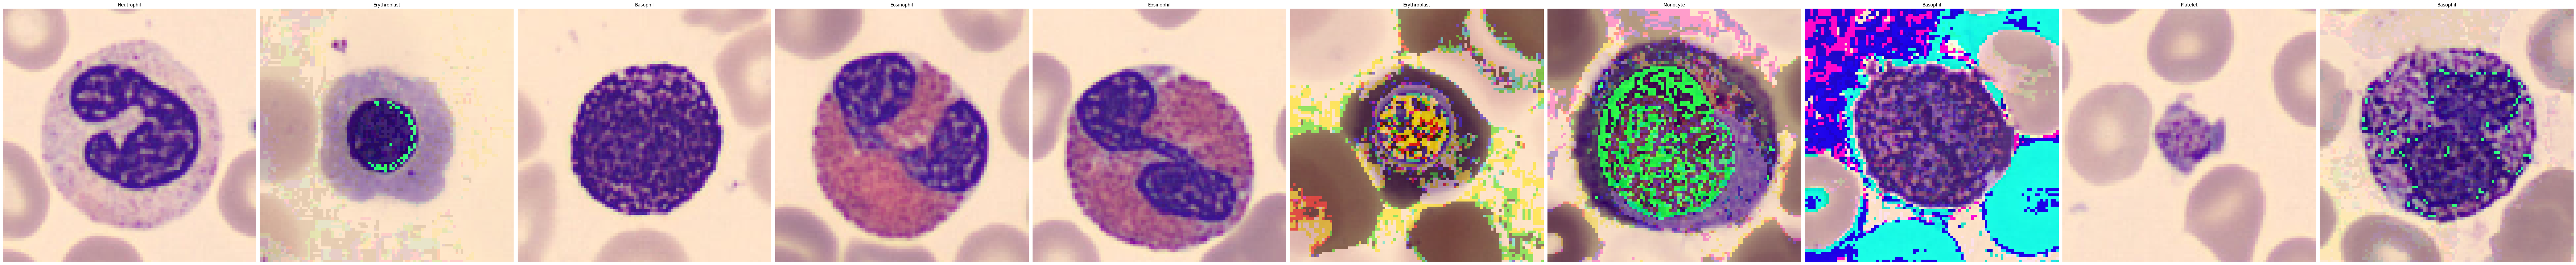

In [3]:
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(96, 96))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(labels[y[idx]])
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [4]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
7    2330
3    2330
6    2330
2    2330
1    2330
5    2330
0    2330
4    2330
Name: count, dtype: int64


In [5]:
# Normalize the data to the range [0, 1] and encode output labels
X = (X / 255).astype('float32')
y = tfk.utils.to_categorical(y, num_classes=len(unique_labels))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=seed)
print(f'Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}')
print(f'Training labels shape: {y_train.shape}, Validation labels shape: {y_val.shape}')

Training data shape: (13048, 96, 96, 3), Validation data shape: (5592, 96, 96, 3)
Training labels shape: (13048, 8), Validation labels shape: (5592, 8)


## A bit of Data Augmentation on Validation Set
Now I want to try to apply some random augmentation effects to the validation set. The goal is to partially change its content, without affecting the training set, and see how the model respond.
I suppose bad performance, let's see...

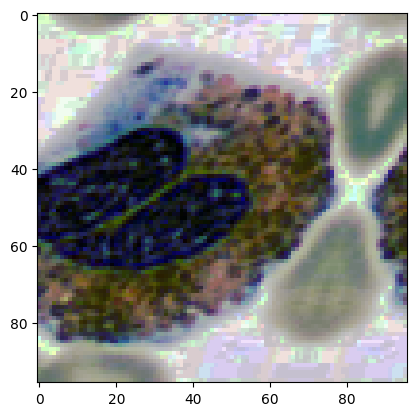

In [6]:
# We try to understand the test set distribution through validation;
# as we don't know how test data is, we use some random augmentation.
X_val_augmented = kcv.layers.RandAugment(value_range=(0, 1), augmentations_per_image=3, magnitude=0.3)(X_val)

# Display a sample of images from the validation dataset
i = 100
plt.imshow(X_val_augmented[i])

# Assign the augmented validation data to the original validation data
X_val = X_val_augmented

## 🛠️ Train and Save the Model

In [7]:
# Hyperparameters
epochs = 100
batch_size = 32
learning_rate = 0.001

# Retrieve input and output shape
input_shape = X_train.shape[1:]
output_shape = y_train.shape[-1]

In [8]:
def build_model (
    input_shape = input_shape,
    output_shape = output_shape,
    learning_rate = learning_rate,
    dropout_rate = 0.5,
    augmentation = None,
    flatten = True,
    seed = seed):

  tf.random.set_seed(seed)

  # Input layer
  inputs = tfkl.Input(shape=input_shape, name='Input')

  # Apply augmentation layers, if specified, and create the first convolutional layer
  if augmentation is None:
    x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', name='Conv2D_1')(inputs)
  else:
    x = augmentation(inputs)
    x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', name='Conv2D_1')(x)
  x = tfkl.MaxPooling2D(pool_size=2, name='MaxPooling2D_1')(x)

  x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='Conv2D_2')(x)
  x = tfkl.ReLU(name='relu2')(x)
  x = tfkl.MaxPooling2D(name='mp2')(x)

  x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv2D_3')(x)
  x = tfkl.ReLU(name='relu3')(x)
  x = tfkl.MaxPooling2D(name='mp3')(x)

  x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='Conv2D_4')(x)
  x = tfkl.ReLU(name='relu4')(x)
  x = tfkl.MaxPooling2D(name='mp4')(x)

  # Flatten layer
  if flatten == True:
    x = tfkl.Flatten(name='Flatten')(x)
  else:
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)

  # Fully connected layers
  x = tfkl.Dense(units=128, name='Dense_1')(x)
  x = tfkl.BatchNormalization(name='BatchNormalization_1')(x)
  x = tfkl.Activation('relu', name='Activation_1')(x)
  x = tfkl.Dropout(rate=dropout_rate, name='Dropout_1')(x)

  x = tfkl.Dense(units=128, name='Dense_2')(x)
  x = tfkl.BatchNormalization(name='BatchNormalization_2')(x)
  x = tfkl.Activation('relu', name='Activation_2')(x)
  x = tfkl.Dropout(rate=dropout_rate, name='Dropout_2')(x)

  # Output layer
  x = tfkl.Dense(units=output_shape, name='Output')(x)
  outputs = tfkl.Activation('softmax', name='Activation_Output')(x)

  # Create the model
  model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN_Model')

  # Compile the model
  loss = tfk.losses.CategoricalCrossentropy()
  optimizer = tfk.optimizers.Adam(learning_rate)
  metrics = ['accuracy']
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

  return model

In [ ]:
# Define a data augmentation pipeline
# Layer performing some geometric operations, that resemble that of the RandAugment
# layer (which was too computationally demanding to be used inside the network).
augmentation = tf.keras.Sequential ([
#      tfkl.RandomFlip(mode="horizontal_and_vertical"),
      tfkl.RandomBrightness(0.2, value_range=(0 ,1)),
      tfkl.RandomTranslation(0.2, 0.2),
      tfkl.RandomZoom(0.2),
      tfkl.RandomRotation(0.2),
      tfkl.RandomContrast(0.2)
], name='augment')

In [10]:
# Early stopping callbacks
patience = 10

# Create an early stopping on validation accuracy
early_stopping_accuracy = tfk.callbacks.EarlyStopping (
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)
callbacks = [early_stopping_accuracy]

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ augment (Sequential)        │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_brightness_1    │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomBrightness)          │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_translation_2   │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomTranslation)         │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_zoom            │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomZoom)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_rotation        │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_contrast_1      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomContrast)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Conv2D_1 (Conv2D)           │ (None, 96, 96, 16)    │        448 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ MaxPooling2D_1              │ (None, 48, 48, 16)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Conv2D_2 (Conv2D)           │ (None, 48, 48, 32)    │      4,640 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu2 (ReLU)                │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp2 (MaxPooling2D)          │ (None, 24, 24, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Conv2D_3 (Conv2D)           │ (None, 24, 24, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu3 (ReLU)                │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp3 (MaxPooling2D)          │ (None, 12, 12, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Conv2D_4 (Conv2D)           │ (None, 12, 12, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu4 (ReLU)                │ (None, 12, 12, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp4 (MaxPooling2D)          │ (None, 6, 6, 128)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ GlobalAveragePooling2D      │ (None, 128)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Dense_1 (Dense)             │ (None, 128)           │     16,512 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ BatchNormalization_1        │ (None, 128)           │        512 │   Y   │
│ (BatchNormalization)        │                       │            │     

 Total params: 132,520 (517.66 KB)

 Trainable params: 132,008 (515.66 KB)

 Non-trainable params: 512 (2.00 KB)

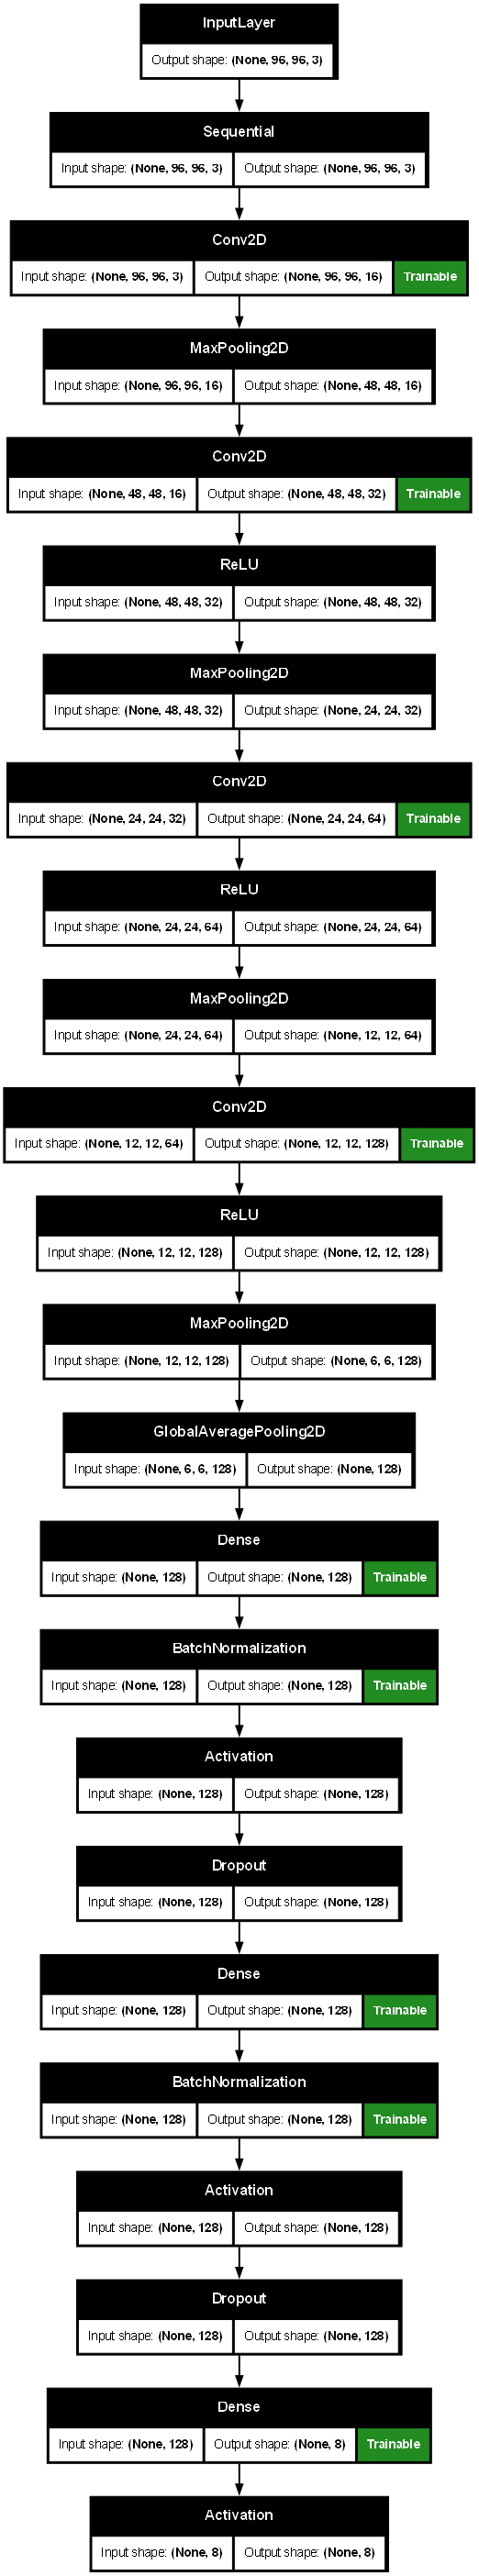

In [11]:
# Build the model with specified input and output shapes
model = build_model(flatten=False, augmentation=augmentation)

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [12]:
history = model.fit (
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'weights.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.2541 - loss: 2.0899 - val_accuracy: 0.1504 - val_loss: 2.1729
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.5179 - loss: 1.2277 - val_accuracy: 0.3054 - val_loss: 2.4365
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step - accuracy: 0.6043 - loss: 1.0057 - val_accuracy: 0.3405 - val_loss: 2.7019
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - accuracy: 0.6809 - loss: 0.8499 - val_accuracy: 0.2736 - val_loss: 3.1880
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.7060 - loss: 0.7706 - val_accuracy: 0.3183 - val_loss: 4.0490
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - accuracy: 0.7528 - loss: 0.6899 - val_accuracy: 0.3868 - val_loss: 3.4240
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.7737 - loss: 0.6354 - val_accuracy: 0.3496 - val_loss: 3.1334
Epoch 8/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step - accuracy: 0.7907 - loss: 0

175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
(5592,)


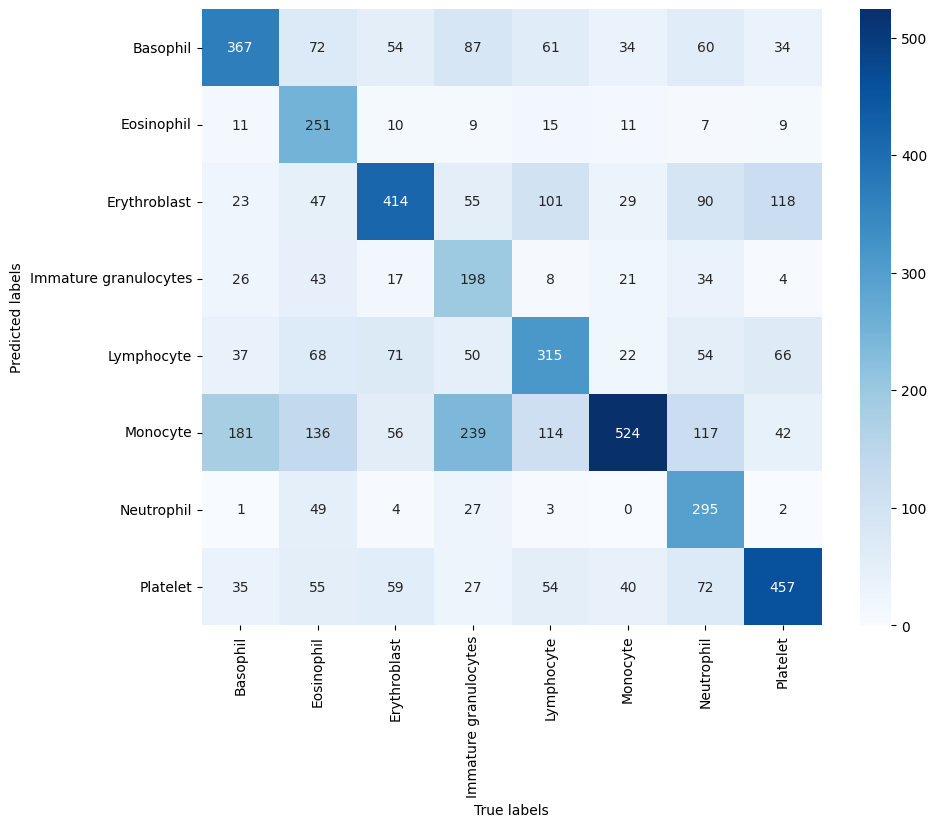

In [13]:
# Load the saved model
model = tfk.models.load_model(model_filename)

# Compute the confusion matrix
predictions = model.predict(X_val)
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_val, axis=-1)

print(pred_classes.shape)
cm = confusion_matrix(true_classes, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, annot=True, fmt='', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

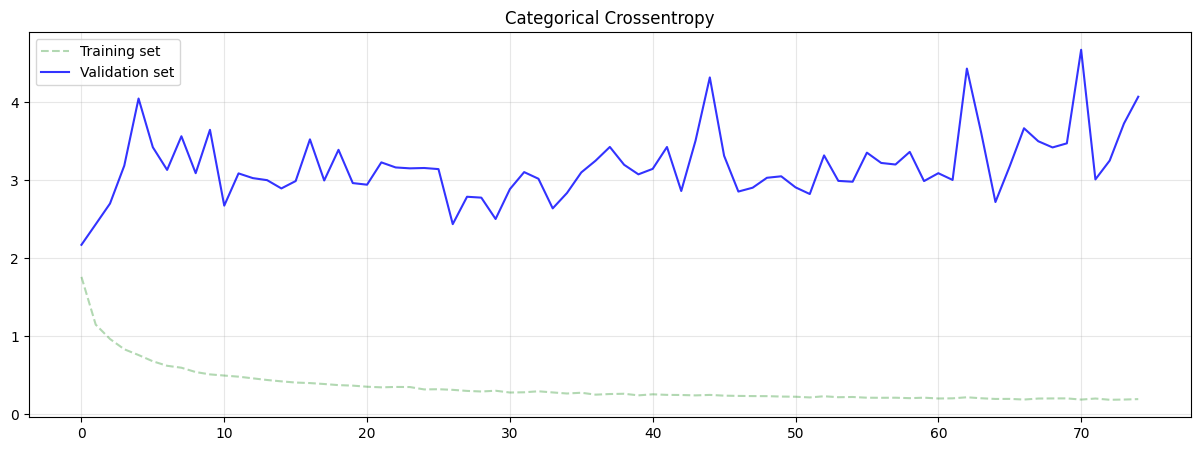

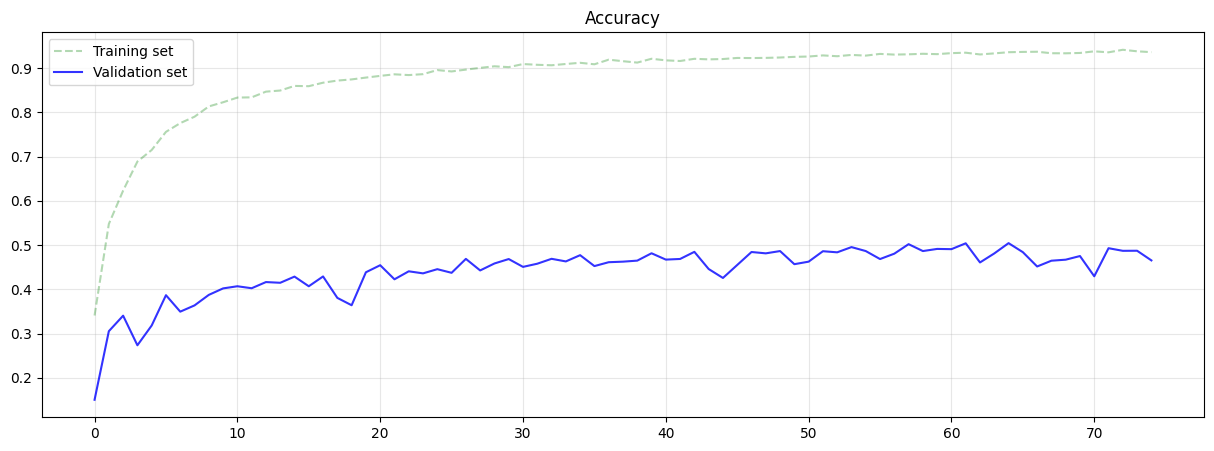

In [14]:
# Plot the loss and accuracy metrics
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(history['val_loss'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training set', alpha=.3, color='green', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation set', alpha=.8, color='blue')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [15]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = X / 255.0
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds
        

Overwriting model.py
